In [11]:
import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt
%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

# I/ Map

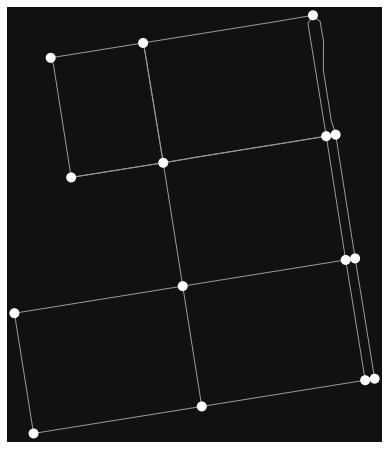

In [12]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 100m from point
MDG = ox.graph_from_point(location_point, dist=200, dist_type="bbox", network_type="drive")
fig, ax = ox.plot_graph(MDG, node_color="white", node_size=100)

MDG = nx.convert_node_labels_to_integers(MDG) # Use label to deal with node id 

MG = ox.utils_graph.get_undirected(MDG) # MultiDiGraph -> MultiGraph
# G = nx.Graph(MG) # MultiDiGraph -> Graph
adjacency = dict([(n, list(nbrdict.keys())) for n, nbrdict in MG.adjacency()])

# II/ Chinese Postman Algorithm

1. List all odd vertices.
2. List all possible pairings of odd vertices.
3. For each pairing find the edges that connect the vertices with the minimum weight.
4. Find the pairings such that the sum of the weights is minimised.
5. On the original graph add the edges that have been found in Step 4.
6. The length of an optimal Chinese postman route is the sum of all the edges added to the total found in Step 4.
7. A route corresponding to this minimum weight can then be easily found.


In [13]:
# 1. List all odd vertices
def list_odd_vertices(adjlist):
    odds = [i for i in range(len(adjlist)) if len(adjlist[i]) % 2 != 0]
    return odds

odds = list_odd_vertices(adjacency)
print(odds)

[3, 4, 5, 9, 12, 13]


In [14]:
# 2. List all possible pairings of odd vertices
def list_all_pairings(odds):
    n = len(odds)
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            pairs.append((odds[i], odds[j]))
    return pairs

pairs = list_all_pairings(odds)
print(pairs)


[(3, 4), (3, 5), (3, 9), (3, 12), (3, 13), (4, 5), (4, 9), (4, 12), (4, 13), (5, 9), (5, 12), (5, 13), (9, 12), (9, 13), (12, 13)]


In [15]:
# def choose_min(dist, M):
#     """
#     dist: distance vector which contains the shortest distance (so far) indexed on the number of vertices
#     M: boolean vector representing the set of vertices that we can choose from (True can be chose, False cannot be chosen)
#     """
#     value_min = inf 
#     vertex_min = None
#     for i in range(len(M)):
#         if M[i] and dist[i]<value_min:
#             value_min = dist[i]
#             vertex_min = i
#     return vertex_min
    
# def Dijkstra_0(G, src):
#     dist = [inf]*G.order
#     M = [True]*G.order
#     p = [None]*G.order
#     visited = []
    
#     p[src] = -1
#     dist[src] = 0
    
#     cpt = 1
#     while src!=None and cpt<G.order:
#         cpt +=1
#         visited.append(src)
#         M[src] = False
#         for adj in G.adjlists[src]:
#             if dist[src]+G.costs[(src,adj)]<dist[adj]:
#                 dist[adj] = dist[src]+G.costs[(src,adj)]
#                 p[adj] = src
#         src = choose_min(dist,M)
#     return (dist,p,visited)

In [20]:
class RegGraph:
    """
        Build regular graph representation from Osmnx graph.
    """
    
    def __init__(self, G):
        self.G = G
        self.adjlist = self.create_adjlist(self.G)
        self.adjmat = self.adjlist_to_adjmat(self.adjlist)
        
    def create_adjlist(self, G):
        adjlist = []
        for src, nbrdict in self.G.adjacency():
            tmp = []
            for dst in nbrdict:
                length = ox.utils_graph.get_route_edge_attributes(G, (src, dst), 'length')[0]
                tmp.append((dst, length))
            adjlist.append((src, tmp))
        return dict(adjlist)
        

    def adjlist_to_adjmat(self, adjlist):
        n = len(self.adjlist)
        adjmat = [[0 for j in range(n)] for i in range(n)]
        for src in range(n):
            for dst, length in self.adjlist[src]:
                adjmat[src][dst] = length
        return adjmat

    def pretty_print_adjmat(self):
        n = len(self.adjmat)

        print("  ",end="")
        for i in range(n):
            print("{} ".format(i), end="")

        print()

        for i in range(n):
            print("{} ".format(i), end="")
            for j in range(n):
                print(self.adjmat[i][j], end="|")
            print()

In [75]:
# 3. For each pairing find the edges that connect the vertices with the minimum weight
def dijkstra(adjlist, src):
    N = len(adjlist)
    
    dist = [float('inf')] * N
    dist[src] = 0
    
    prev = [None] * N
    
    visited = [False] * N
    
    queue = [src]
    while (queue != []):
        u = queue.pop()
        visited[u] = True
        for v, weight in adjlist[u]:
            if (not visited[v]):
                queue.append(v)
            d = dist[u] + weight
            if (d < dist[v]):
                dist[v] = d
                prev[v] = u        
    return prev

def min_path_pair(adjlist, pair):
    (src, dst) = pair
    prev = dijkstra(adjlist, src)
    res = [dst]
    while (src != dst):
        dst = prev[dst]
        res.insert(0, dst)
    return res

def find_min_paths(adjlist, pairs):
    paths = [min_path_pair(adjlist, pairs[i]) for i in range(len(pairs))]
    return paths

{0: [(7, 107.41299999999998), (4, 104.53099999999998), (1, 80.185), (11, 142.02499999999998)], 1: [(0, 80.185), (2, 104.55999999999999)], 2: [(1, 104.55999999999999), (4, 80.533)], 3: [(4, 148.028), (11, 106.508), (12, 106.86899999999999)], 4: [(0, 104.53099999999998), (3, 148.028), (2, 80.533)], 5: [(9, 142.37199999999999), (6, 146.526), (7, 104.785)], 6: [(5, 146.526), (8, 104.738)], 7: [(0, 107.41299999999998), (5, 104.785), (8, 146.656), (10, 141.957)], 8: [(6, 104.738), (7, 146.656)], 9: [(5, 142.37199999999999), (14, 8.224), (10, 104.81700000000001)], 10: [(7, 141.957), (9, 104.81700000000001), (11, 107.72500000000001), (13, 8.222999999999999)], 11: [(0, 142.02499999999998), (3, 106.508), (12, 8.228), (10, 107.72500000000001)], 12: [(11, 8.228), (3, 106.86899999999999), (13, 107.75699999999999)], 13: [(10, 8.222999999999999), (12, 107.75699999999999), (14, 104.816)], 14: [(9, 8.224), (13, 104.816)]}
[0, 4, 2]


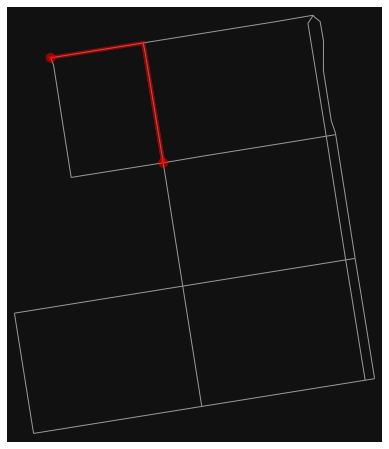

[0, 1, 2]


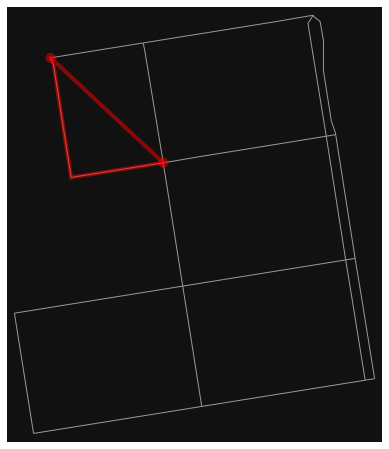

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [81]:
G = RegGraph(MG) 
adjlist = G.create_adjlist(MG)
print(adjlist)
#print(dijkstra(adjlist, 0))

route = ox.shortest_path(MG, 0, 2, weight="travel_time")
fig, ax = ox.plot_graph_route(MG, route, node_size=0)

route = min_path_pair(adjlist, (0, 2))
ox.plot_graph_route(MG, route, node_size=0, route_color="blue")

# min_paths = find_min_paths(, pairs)
# print(min_paths)

# G.pretty_print_adjmat()

#pos = nx.spring_layout(G)

# # nodes
# nx.draw_networkx_nodes(G, pos)

# # edges
# labels = nx.get_edge_attributes(G,'weight')
# length = ox.utils_graph.get_route_edge_attributes(G, (0, 1), 'length')[0]


# nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# plt.show()
